# Analyse der Störungen der S-Bahn München.

In [1]:
# Helpful functions
import pandas as pd
import numpy as np
import seaborn as sns
import re

# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as cm

In [2]:
sns.set()

Die letzten Wochen bzw. schon das gesamte Jahr 2018 war eine Katastrophe für die S-Bahn München (https://www.sueddeutsche.de/muenchen/oeffentlicher-nahverkehr-die-muenchner-s-bahn-ist-ein-desaster-1.3890138). Allerdings hat jeder einen subjektiven Eindruck von den Störungen und es gibt einen gewissen Bias bei der Auswahl (andere Strecke, andere Fahrgewohnheiten). Ich fahre selbst häufiger gegen späten Vormittag oder frühen Nachmittag, wohingegen andere ganz früh in die Arbeit oder sehr spät von der Arbeit heimkehren können.

Um die Störungen systematisch anzugehen ist eine Datengrundlage nötig, die alle Störungen beinhaltet und zusätzliche infos (betroffene S-Bahnen) bereitstellt. Die Bahn veröffentlicht selbst zu jeder Störung eine kurze Nachricht, die alle diese Daten beinhaltet. Allerdings gibt es keinen Weg an die Daten der Bahn direkt zu kommen.

Es gibt allerdings Webseiten, welche diese Störungen selbst publizieren und überwachen. Meine Daten der Störungen sind netterweise bereitgestellt von der Website Störticker (https://stoerticker.de/aktuell?evu=2).

## Update April 2021

Ich habe diese Analyse ursprünglich im Jahr 2018 durchgeführt. Seitdem sind fast drei Jahre vergangen und die Corona Krise bietet die Möglichkeit, sich den Fall anzusehen, dass weniger Menschen in den öffentlichen Verkehrsmitteln fahren und welchen Einfluss dies hat.

Dafür habe ich mir einen neuen Datensatz von Störticker besorgt, der nun bis April 2021 geht. Grundsätzlich sammelt Störticker alle Störungsmeldungen, die die S-Bahn München über ihre Apps bzw. Website herausgibt und archiviert diese auch. Diese Störungsmeldungen sind unstrukturierte Daten, die lediglich ein Datum und eine Störungsmeldung beinhalten. Um diese Daten zu verarbeiten, ist eine aufwändige Bereinigung nötig.

## Anmerkungen und Beschränkungen der Analyse

- Die größte Einschränkung ist die Art, wie wir an die Störungen kommen und wie sie bei der S-Bahn München gemeldet werden. Wir sind abhängig davon, dass Störungen ihren Weg in den Störticker finden. Dabei beobachten wir nicht die Störungen selbst, sondern nur die Meldungen des Störtickers, die veröffentlicht werden. Sofern also die S-Bahn München etwas an der Art, wie oder gerade auch welche Störungen sie veröffentlicht, ändert, werden wir diese Änderung in den Daten beobachten. Hier könnten wir fälschlicherweise den Schluss ziehen, dass wir einen Trend in den Daten beobachten, wenn wir eigentlich nur einen Trend in der Veröffentlichung der Daten beobachten. Sofern die S-Bahn München in den letzten Jahren vermehrt auch kleinere Störungen veröffentlicht, würden wir vermuten, dass die Störungen zunehmen, wobei eigentlich nun nur auch kleinere Störungen gemeldet werden. Was hier einschränkend wirkt ist der Fakt, dass diese Umstellungen punktuell und nicht so häufig graduell erfolgen sollten. Man dürfte also einen Bruch in der Zeitreihe sehen, aber danach müssten die Störungen entweder stagnieren oder sogar zurückgehen, sofern die für die Gesundheit der S-Bahn ergriffenen Maßnahmen wirken.
- Die Daten von Störticker sind vollständig außer für drei Tage im März 2020. Das soll uns nicht weiter stören, weil wir insgesamt fast 20.000 Störmeldungen von 01.01.2014 bis 30.03.2021 haben. Diese bereinigen und filtern wir bis wir noch etwa 8500 Meldungen übrig haben, die wir eingehender analysieren.
- Die Daten müssen aus verschiedenen Gründen bereinigt und gefiltert werden. Zum einen nutzt die S-Bahn München ihre Störticker nicht nur für Störmeldungen, sondern auch für Updates zum 10-Minuten-Takt oder andere Ankündigungen. Zum anderen können für eine Störung teils mehrere Meldungen verfasst werden. Häufig gibt es eine initiale Meldung, verschiedene Zwischenmeldungen und eine Meldung, die das Ende der Störung verkündet. Dies müssen wir filtern bis auf die initiale Meldung.
- Auch nach eingehender und gewissenhafter Aussortierung doppelter Meldungen können wir nicht endgültig sicherstellen, keine Meldung doppelt zu zählen. Es ist nicht möglich, 20.000 Meldungen von Hand zu sortieren. Deshalb müssen wir uns auf gewisse Regeln und Hilfen verlassen. Wir entfernen Duplikate, sofern diese direkt aufeinander folgen. Ein Beispiel hierfür ist die Meldung der Sperrung der Stammstrecke, welche sehr häufig wiederholt wird. Sofern dazwischen allerdings eine andere Meldung folgt, ist es uns nicht recht möglich, dies zuzuordnen. Es könnte ja eine erneute Störung sein. Weiterhin scannen wir den Text nach Signalwörtern, wie "behoben", "endmeldung" oder "beendet" und sortieren diese Meldungen ebenfalls aus. Auch Meldungen mit dem Text "Fahrplanänderung" sortieren wir aus. Der berühmte kurzfristige Rückstau im Berufsverkehr ist ebenfalls entfernt, auch wenn er an sich eine Störung wäre.
- Leider haben wir wenig Einblick in die Schwere oder die Dauer der Störmeldungen. Wir wissen nicht, welche Meldung zu Verspätungen oder Ausfällen führt und wie schwerwiegend diese sind. Eine noch tiefere Analyse müsste die einzelnen Meldungen nach ihrem Härtegrad gewichten und entsprechend aufsummieren, um einen Indikator für die Schwere der Störungen und nicht nur die Häufigkeit zu erhalten. Dabei ist allerdings offen, wie man die Schwere einer Störung bestimmen würde. Man könnte die Verspätungen der Züge addieren (die maximale Verspätung oder die an ihrem Zielbahnhof?). Dabei bleibt offen, um wie viel ein ausgefallener Zug verspätet ist. Diese Daten liegen uns aber auch nicht vor und würden den Rahmen dieser Analyse sprengen.

## Datensatz: Störungsmelder

Wir laden den Datensatz zu den Störungen und analysieren erst einmal die Struktur der Daten, bevor wir anfangen unsere tiefergehenden Analysen durchzuführen.

Es gibt in der Datenbank ein paar Einträge, die doppelt oder dreifach in die Datenbank geschrieben wurden. Diese entfernen wir und räumen auf. Außerdem schließen wir November von der Analyse aus, weil der Monat noch nicht zu Ende ist und Mittelwerte über die Anzahl der Störungen beeinlussen würde. Das gleiche gilt für den ersten Monat, für den wir Daten haben, September 2013.

In [3]:
stoerungen_raw = pd.read_excel('stoerungen.xlsx')
stoerungen_raw = stoerungen_raw.drop(['id', 'meldung'], axis=1)

stoerungen_raw.columns = ['Text', 'Date']
stoerungen_raw.index = stoerungen_raw['Date']
stoerungen_raw.index.name = None
stoerungen_raw = stoerungen_raw[~stoerungen_raw['Text'].isnull()]

# Error in database - take out the day
stoerungen_raw.groupby('Date').count().sort_values(by='Text', ascending=False).head(10)

# November is manipulating our plots - do not show anything for november yet
stoerungen_raw = stoerungen_raw[stoerungen_raw.index <= '2021-03-31']

# First month: September 2013 is also manipulating our data
stoerungen_raw = stoerungen_raw[stoerungen_raw.index >= '2014-01-01']

stoerungen_raw = stoerungen_raw.drop_duplicates()
stoerungen_raw.index = stoerungen_raw['Date']

In [236]:
stoerungen_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19770 entries, 2014-01-01 06:19:00 to 2021-03-30 20:44:05
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Text           19770 non-null  object        
 1   Date           19770 non-null  datetime64[ns]
 2   Original_Text  19770 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 617.8+ KB


Wir haben Daten von Januar 2014 bis Ende Oktober 2018. Es sind insgesamt 10.379 Störungsmeldungen. Um ein Gefühl für die Daten zu bekommen schauen wir uns die Häufigkeit der verwendeten Worte an und sortieren nach Häufigkeit absteigend. Um ein Gefühl für die Art der Meldungen zu bekommen kann man auch in das Archiv sehen: https://stoerticker.de/archiv?evu=2.

In [161]:
stoerungen_raw['Original_Text'] = stoerungen_raw['Text']
stoerungen_raw['Text'] = stoerungen_raw['Original_Text'].str.lower() \
    .str.strip() \
    .str.replace('&amp;', '&') \
    .str.replace('&quot;', '"') \
    .str.replace('&ndash;', '-') \
    .str.replace('&ouml;', 'ö') \
    .str.replace('ã¶', 'ö') \
    .str.replace('&auml;', 'ä') \
    .str.replace('ã„', 'ä') \
    .str.replace('ã¤', 'ä') \
    .str.replace('&uuml;', 'ü') \
    .str.replace('Ã¼', 'ü') \
    .str.replace('ã¼', 'ü') \
    .str.replace('&szlig;', 'ß') \
    .str.replace('ãÿ', 'ß')

text = stoerungen_raw['Text'] \
    .str.replace(':', '') \
    .str.replace('#', '') \
    .str.replace('/', ' ') \
    .str.replace('\n', '') \
    .str.replace('.', ' ') \
    .str.replace(',', ' ') \
    .str.replace('-', '') \
    .str.replace('(', ' ') \
    .str.replace(')', '') \
    .str.cat(sep=' ')
words = np.unique(text.split(' '))
word_count = dict()
for word in words:
    word_count[word] = text.count(word)
word_count = pd.Series(word_count).to_frame()
word_count.columns = ['Count']
word_count['Word'] = word_count.index

<ipython-input-161-e7c447a678aa>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  text = stoerungen_raw['Text'] \


In [162]:
stoerungen_raw.head()

,Text,Date,Original_Text
Date,,,
2014-01-01 06:19:00,stammstrecke: notarzteinsatz / verzögerungen ...,2014-01-01 06:19:00,stammstrecke: notarzteinsatz / verzögerungen ...
2014-01-01 07:34:00,stammstrecke: feueralarm münchen hbf / s-bahne...,2014-01-01 07:34:00,stammstrecke: feueralarm münchen hbf / s-bahne...
2014-01-01 08:00:00,stammstrecke: polizeieinsatz / streckensperrun...,2014-01-01 08:00:00,stammstrecke: polizeieinsatz / streckensperrun...
2014-01-01 08:13:00,1. aktualisierung stammstrecke: streckensperru...,2014-01-01 08:13:00,1. aktualisierung stammstrecke: streckensperru...
2014-01-01 12:33:00,s 4 ebersberg: personen am gleis / streckenspe...,2014-01-01 12:33:00,s 4 ebersberg: personen am gleis / streckenspe...


In [163]:
word_count[word_count['Word'].apply(lambda x: len(str(x))) > 5].sort_values(by='Count', ascending=False).head(30)

,Count,Word
störung,9457,störung
strecke,7025,strecke
verzögerung,5556,verzögerung
verzögerungen,5471,verzögerungen
beeinträchtigung,5321,beeinträchtigung
beeinträchtigungen,5303,beeinträchtigungen
aktualisierung,4859,aktualisierung
stammstreck,4277,stammstreck
stammstrecke,4276,stammstrecke
technisch,4205,technisch


In [164]:
word_count[word_count['Word'].str.startswith('signal')]

,Count,Word
signal,2279,signal
signalanlagen,41,signalanlagen
signalen,127,signalen
signalstörung,1255,signalstörung
signalstörungen,17,signalstörungen


Wir identifizieren folgende "hot words", d.h. Wörter, die häufig im Zusammenhang mit Störungen stehen und nach denen wir in den Meldungen suchen.

In [165]:
hot_words = [
    'störung',
    'verzögerung',
    'verzögerungen',
    'ausfall',
    'beeinträchtigung',
    'beeinträchtigungen',
    'sperrung',
    'streckensperrung',
    'signal',
    'signalstörung',
    'bahnübergang',
    'polizeieinsatz',
    'personen im gleis',
    'stellwerk',
    'polizeiliche ermittlungen',
    'notarzteinsatz',
    'geänderte linienführung',
    'weiche',
    'weichenstörung',
    'oberleitung',
    'feuerwehr',
    'ärztliche versorgung',
    'gegenstände im gleis',
]

Eine interessante erste Analyse ist die Anzahl der Störungsmeldungen pro Monat. Allerdings muss man hier bedenken, dass wir noch keine Aktualisierungen oder sonstige Meldungen, die offensichtlich keine Störungen sind, herausfiltern.

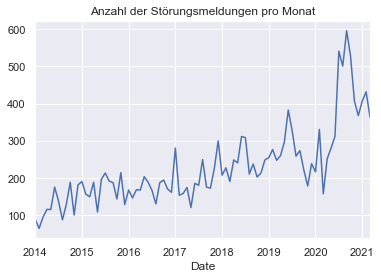

In [166]:
#stoerungen_raw['Text'].groupby(pd.Grouper(freq='W')).count().plot()
stoerungen_raw['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Anzahl der Störungsmeldungen pro Monat')
plt.savefig("monatliche_stoeorungen.png", dpi=300)
plt.show()

In [167]:
test_df = stoerungen_raw_filtered.loc[stoerungen_raw_filtered.index >= '2020-08-03 12:00:00', ('Text',)].head(50)
test_df["diff"] = test_df["Text"].shift(1) == test_df["Text"]
test_df['Text'].values

array(['s 3 mammendorf: gegenstände in der oberleitung / schienenersatzverkehr',
       'stammstrecke: ärztliche versorgung eines fahrgastes / verzögerungen richtung münchen ost',
       's 7 wolfratshausen / s 20 höllriegelskreuth: personen im gleis / streckensperrung',
       's 4/6 ebersberg: polizeieinsatz / beeinträchtigungen',
       's 4 geltendorf: störung an einem bahnübergang / verzögerungen',
       'stammstrecke: störung an der strecke / verzögerungen',
       's 4 / s 6 ebersberg: signalstörung / verzögerungen',
       's3 mammendorf: beschädigte brücke / kein zugverkehr',
       's 7 kreuzstraße: bahnübergangsstörung / verspätungen von bis zu 15 minuten',
       's 4/6 ebersberg: fahrzeugstörung / verzögerungen',
       's 7 wolfratshausen: bahnübergangsstörung / verspätungen von bis zu 10 minuten',
       'stammstrecke: feuerwehreinsatz am münchen karlsplatz / s-bahnen halten nicht am münchen karlsplatz / update folgt',
       'stammstrecke: verzögerungen',
       's 8 h

In [168]:
# Filter out certain words that have nothing to do with problems
filter_out_list = [
    'zusatzangebot mit bussen',
    'aktualisierung',
    '10-minuten-takt',
    'kurzfristiger rückstau im berufsverkehr',
    'fahrplananpassungen',
    'endmeldung',
    'stellwerksstörung behoben',
    'rückkehr zum regelfahrplan bei der s-bahn münchen',
    'bauarbeiten auf der stammstrecke',
    'behoben',
    'stammstrecke: bauarbeiten',
    'vorangegangen',
    'sperrung aufgehoben',
    'wieder aufgenommen',
    'wieder normalisiert',
    'verkehrslage normalisiert sich',
    'einstellung der zusatzangebote mit bussen',
    'weiterhin beeinträchtigungen',
    'ist eingerichtet',
    'wieder auf regelweg',
    'beseitigt',
    'beendet',
    'weiterhin',
    'normalisiert',
    'stabilisiert',
    'aufgehoben',
    'personen im gleis aufgegriffen',
    'ergänzung'
]
stoerungen_raw_filtered = stoerungen_raw.loc[~stoerungen_raw['Text'].str.contains('|'.join(filter_out_list))]

# Filter out consecutive duplicates
stoerungen_raw_filtered = stoerungen_raw_filtered.loc[~(stoerungen_raw_filtered.loc[:, 'Text'].shift(1) == stoerungen_raw_filtered.loc[:, 'Text'])]

# Filter out duplicates on same day
stoerungen_raw_filtered['Day_of_Text'] = stoerungen_raw_filtered.index.date
stoerungen_raw_filtered = stoerungen_raw_filtered.loc[~stoerungen_raw_filtered.duplicated(['Text', 'Day_of_Text'], keep='first'), :]

# Filter also consecutive almost duplicates
slice_indices = stoerungen_raw_filtered.loc[:, 'Text'].str.rfind(' / ')
main_text = pd.Series([x[:y] for x, y in zip(stoerungen_raw_filtered['Text'], slice_indices)])
main_text.index = stoerungen_raw_filtered.index
stoerungen_raw_filtered = stoerungen_raw_filtered.loc[~(main_text.shift(-1) == main_text) & ~(main_text.shift(-2) == main_text)]

stoerungen_raw_filtered.shape

(8438, 4)

In [169]:
stoerungen_raw_filtered.head()

,Text,Date,Original_Text,Day_of_Text
Date,,,,
2014-01-01 06:19:00,stammstrecke: notarzteinsatz / verzögerungen ...,2014-01-01 06:19:00,stammstrecke: notarzteinsatz / verzögerungen ...,2014-01-01
2014-01-01 07:34:00,stammstrecke: feueralarm münchen hbf / s-bahne...,2014-01-01 07:34:00,stammstrecke: feueralarm münchen hbf / s-bahne...,2014-01-01
2014-01-01 08:00:00,stammstrecke: polizeieinsatz / streckensperrun...,2014-01-01 08:00:00,stammstrecke: polizeieinsatz / streckensperrun...,2014-01-01
2014-01-01 12:33:00,s 4 ebersberg: personen am gleis / streckenspe...,2014-01-01 12:33:00,s 4 ebersberg: personen am gleis / streckenspe...,2014-01-01
2014-01-02 08:21:00,stammstrecke: verzögerungen richtung münchen-o...,2014-01-02 08:21:00,stammstrecke: verzögerungen richtung münchen-o...,2014-01-02


#### Manuelle Suche nach Duplikaten

Die meisten Störungen finden wir an folgenden Tagen:

In [170]:
stoerungen_raw_filtered['Text'].groupby(pd.Grouper(freq='D')).count().sort_values(ascending=False).head(10)

Date
2014-12-29    14
2020-09-18    14
2019-01-09    14
2020-07-01    13
2020-12-10    13
2020-11-10    13
2016-04-05    13
2020-09-16    13
2015-02-03    13
2020-09-07    13
Name: Text, dtype: int64

In [171]:
dates_with_most_stoerungen = stoerungen_raw_filtered['Text'].groupby(pd.Grouper(freq='D')).count().sort_values(ascending=False).head(50).index.date

In [172]:
selected_date = dates_with_most_stoerungen[3]
selected_date

datetime.date(2020, 7, 1)

In [237]:
test_df = stoerungen_raw_filtered.loc[stoerungen_raw_filtered.index.date == selected_date, ('Text',)]
test_df['Text'].values

array(['stammstrecke: feuerwehreinsatz am münchen karlsplatz / s-bahnen halten nicht am münchen karlsplatz / update folgt',
       's 2 erding: technische störung an einem bahnübergang / verzögerungen / teilausfälle möglich',
       's 1 freising/flughafen: technische störung an einer weiche / beeinträchtigungen / verzögerungen / teilausfälle / umleitungen',
       'stammstrecke/gesamtnetz: weichenstörung münchen ostbahnhof / abweichende linienführung / verspätungen / teilausfälle',
       's 2 erding: signalstörung in münchen riem / züge werden umgeleitet / verspätungen / teilausfälle',
       's 7 wolfratshausen: fahrzeugstörung / beeinträchtigungen / verzögerungen von 10 bis 15 minuten / teilausfälle möglich',
       's 2 erding: störung an einem bahnübergang / verzögerungen',
       's 3 holzkirchen: unfall an einem bahnübergang / sperrung',
       's 3 holzkirchen: unfall an einem bahnübergang / sperrung / schienenersatzverkehr',
       'stammstrecke: polizeiliche ermittlungen / b

#### Frequenz des kurzfristigen Rückstaus im Berufsverkehr

In [174]:
kurzfristiger_rückstau = stoerungen_raw.loc[stoerungen_raw['Text'].str.contains('kurzfristiger rückstau im berufsverkehr'), 'Text']
kurzfristiger_rückstau = kurzfristiger_rückstau.groupby(pd.Grouper(freq='D')).count()

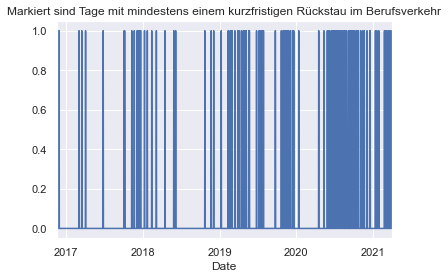

In [175]:
kurzfristiger_rückstau[kurzfristiger_rückstau >= 1] = 1
kurzfristiger_rückstau.plot(title='Markiert sind Tage mit mindestens einem kurzfristigen Rückstau im Berufsverkehr')
plt.show()

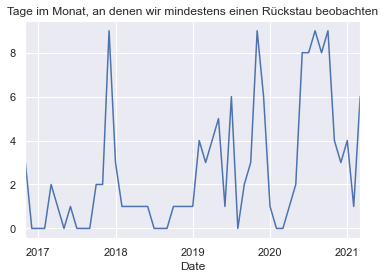

In [176]:
kurzfristiger_rückstau.groupby(pd.Grouper(freq='M')).sum().plot(title='Tage im Monat, an denen wir mindestens einen Rückstau beobachten')
plt.show()

#### Analyse spezifischer Störungsmeldungen

In [177]:
def frequency_of_disruption(disruption):
    with_disruptions = stoerungen_raw_filtered.loc[stoerungen_raw_filtered['Text'].str.contains(disruption), 'Text']
    disruptions_per_day = with_disruptions.groupby(pd.Grouper(freq='D')).count()
    disruptions_per_day.plot(title=f'Häufigkeit der Störung "{disruption}" an diesem Tag')
    plt.show()
    
    disruptions_per_month = disruptions_per_day.groupby(pd.Grouper(freq='M')).sum()
    disruptions_per_month.plot(title=f'Häufigkeit der Störung "{disruption}" in diesem Monat')
    plt.show()

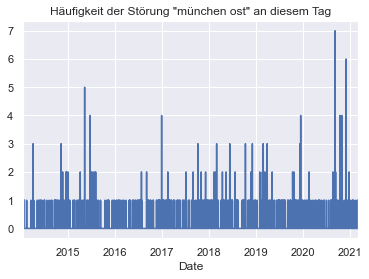

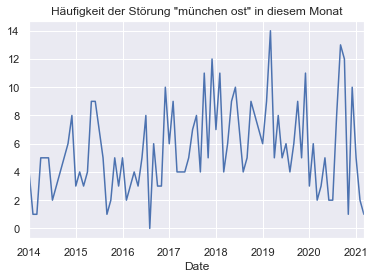

In [178]:
frequency_of_disruption('münchen ost')

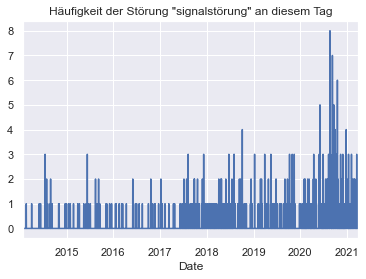

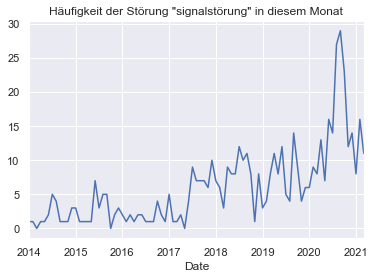

In [179]:
frequency_of_disruption('signalstörung')

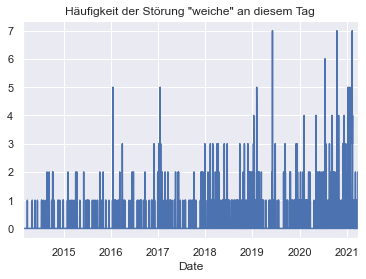

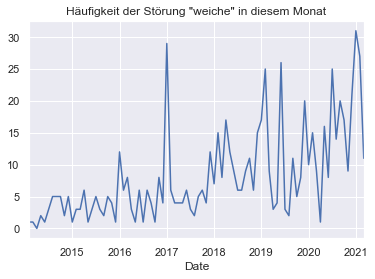

In [180]:
frequency_of_disruption('weiche')

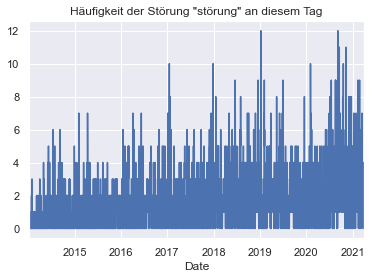

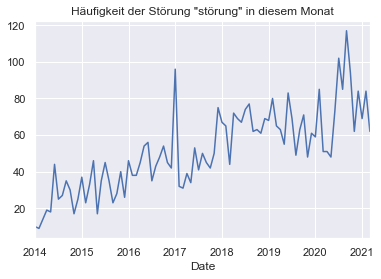

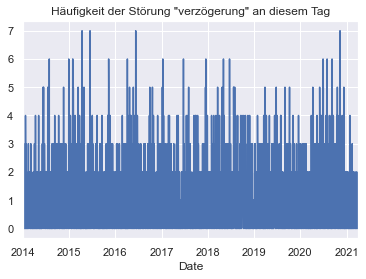

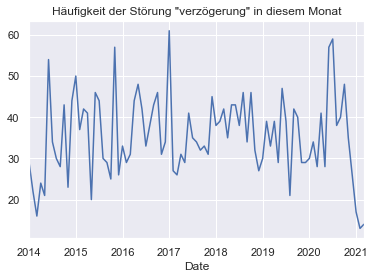

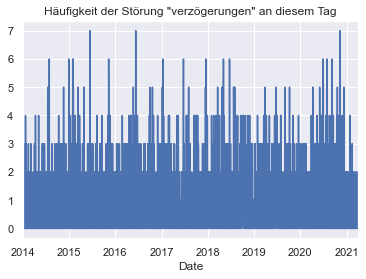

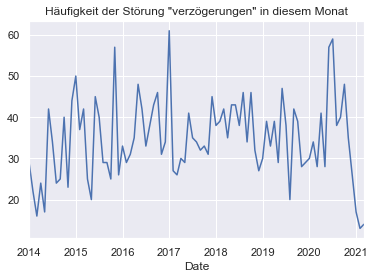

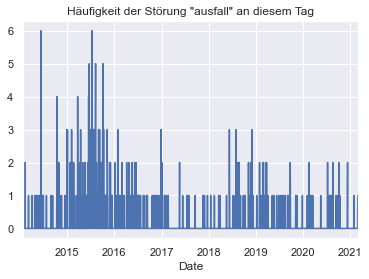

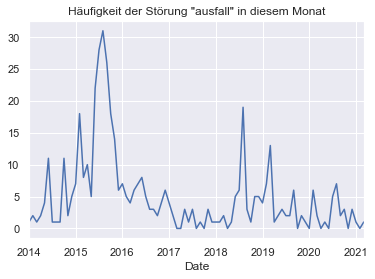

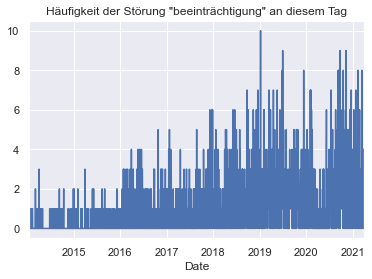

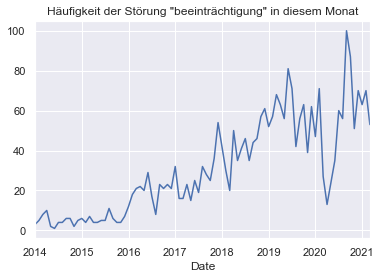

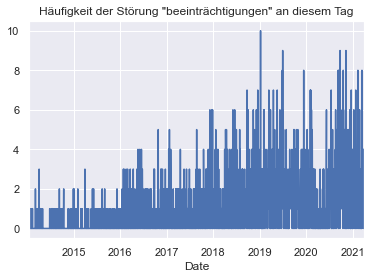

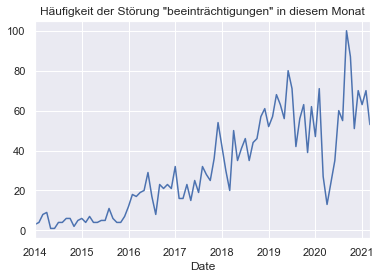

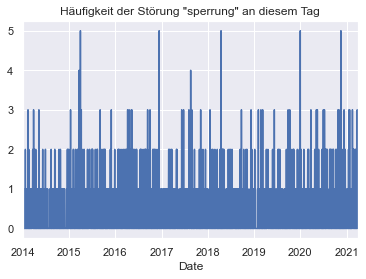

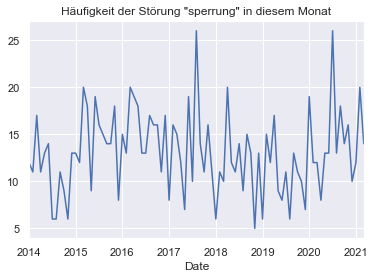

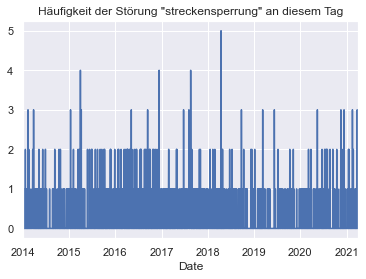

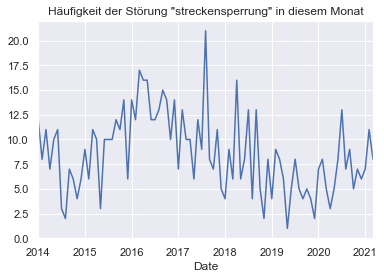

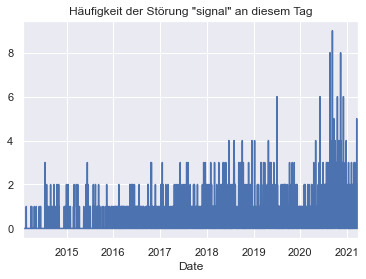

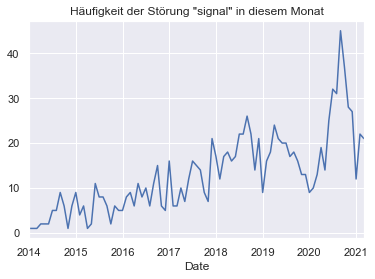

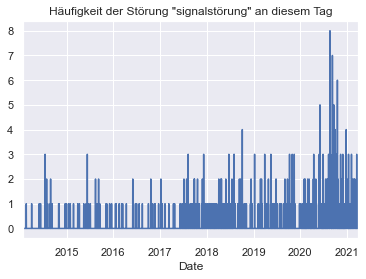

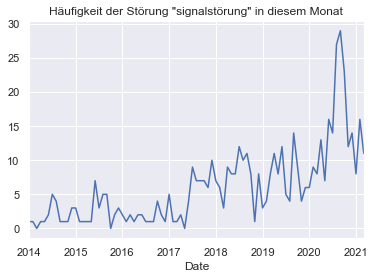

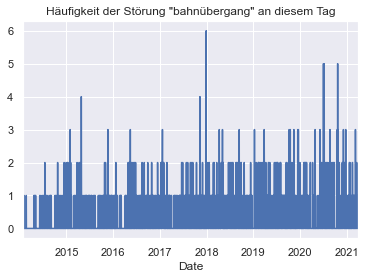

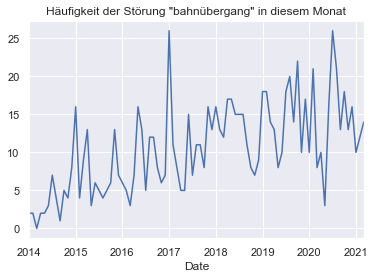

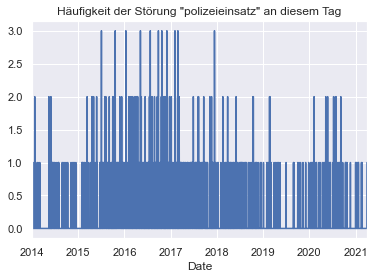

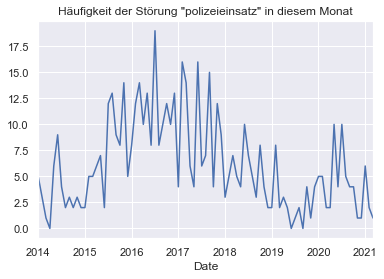

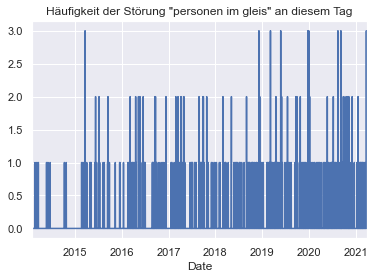

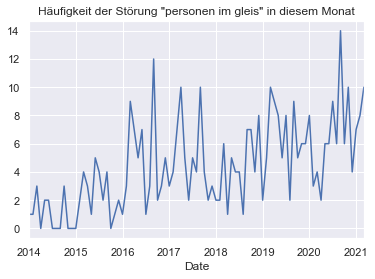

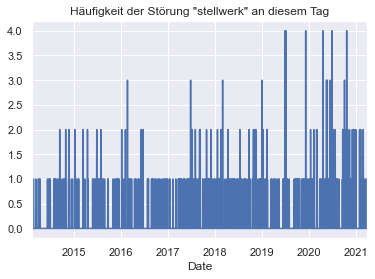

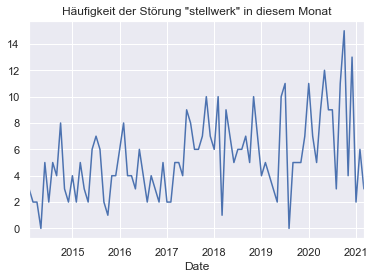

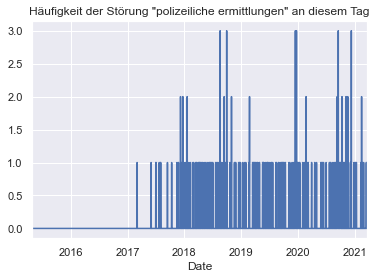

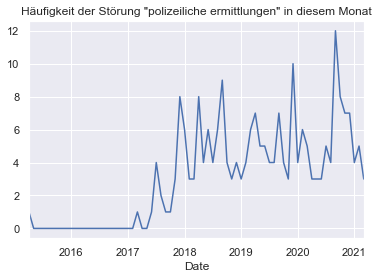

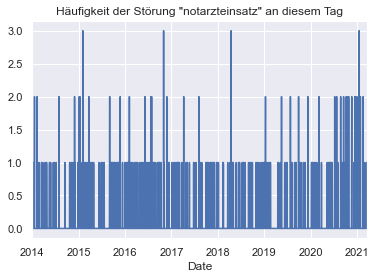

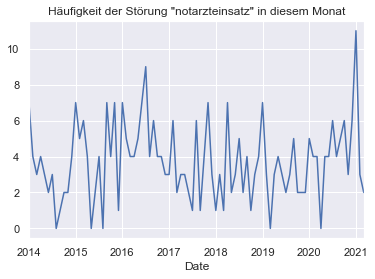

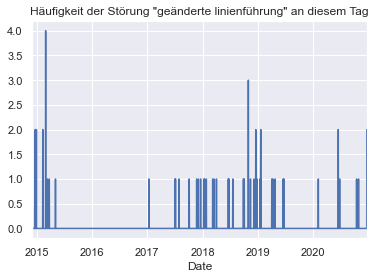

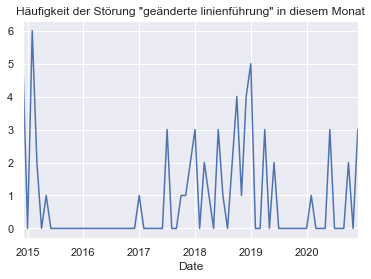

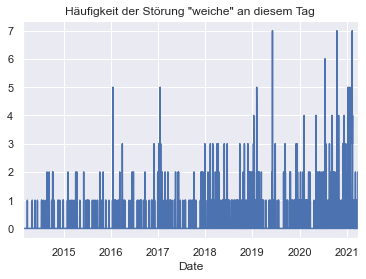

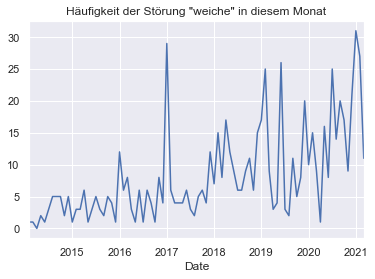

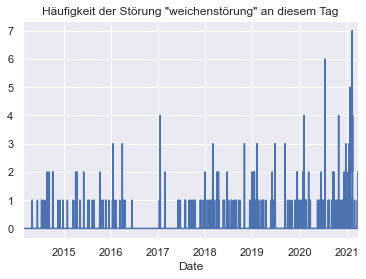

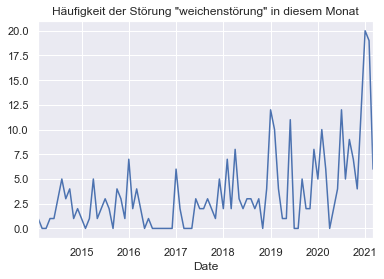

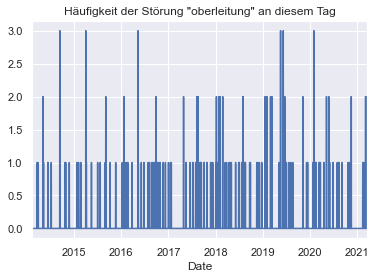

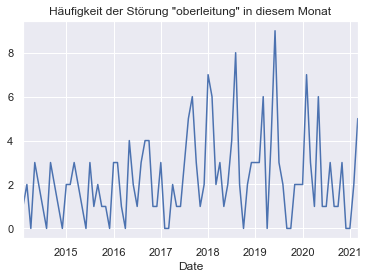

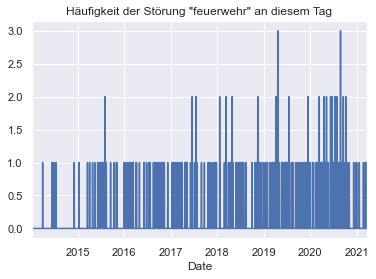

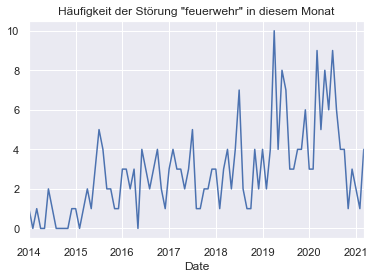

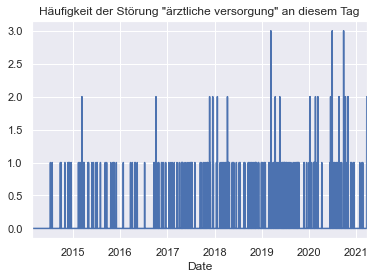

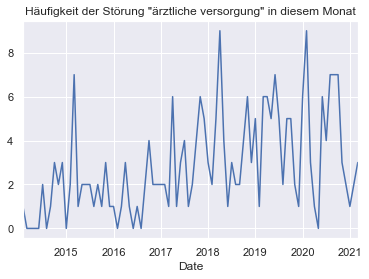

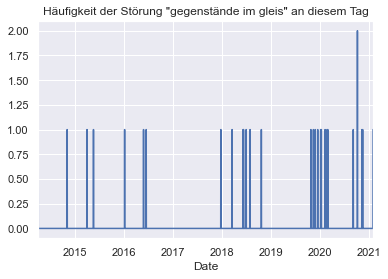

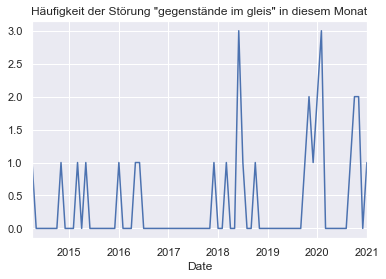

In [181]:
for word in hot_words:
    frequency_of_disruption(word)

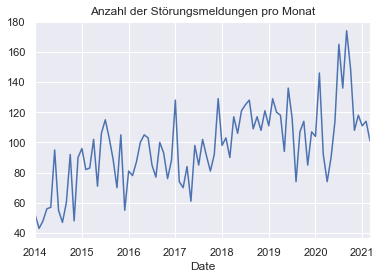

In [182]:
stoerungen_raw_filtered['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Anzahl der Störungsmeldungen pro Monat')
plt.show()

Im nächsten Schritt sehen wir uns die Verwendung der "hot words" in Meldungen an. Wir filtern die Meldungen, welche diese Worte beinhalten.

In [183]:
stoerungen_hotwords = stoerungen_raw_filtered[stoerungen_raw_filtered['Text'].str.contains('|'.join(hot_words))]

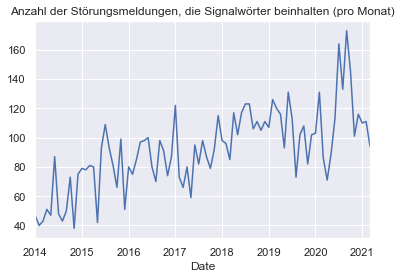

In [184]:
stoerungen_hotwords['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Anzahl der Störungsmeldungen, die Signalwörter beinhalten (pro Monat)')
plt.savefig("monatliche_stoeorungen_hotwords.png", dpi=300)
plt.show()

Wenn man sich die Struktur einer Meldung genauer ansieht, dann beschreibt der Text vor dem ersten Doppelpunkt meist die Art der Meldung (Aktualisierung / Störung / etc.) und nennt die betroffenen S-Bahnen und der darauffolgende Text gibt Details zur Art der Störung. Deshalb spalten wir nun alle Meldungen in genau diese Bestandteile zur genaueren Analyse.

In [247]:
text_split = stoerungen_raw_filtered['Text'].str.lower().str.strip()
#text_split = stoerungen_hotwords['Text'].str.lower().str.strip()

regexp = r'(.+):{1} {1}(.*)\({1}(.+)[\)9]{0,1}'
res = text_split.str.extract(pat=regexp, expand=True)
res.columns = ['Type', 'Text', 'Date']
nantext = pd.isnull(res['Type'])
res.loc[nantext, 'Type'] = text_split[nantext]
res.loc[nantext, 'Text'] = text_split[nantext]
print('No match for {} entries'.format(np.sum(nantext)))

# stoerungen = res[~nantext]
stoerungen = res
stoerungen.head()

No match for 1520 entries


,Type,Text,Date
Date,,,
2014-01-01 06:19:00,stammstrecke,notarzteinsatz / verzögerungen,"stand 01.01.2014, 06:20 uhr)"
2014-01-01 07:34:00,stammstrecke,feueralarm münchen hbf / s-bahnen verkehren oh...,"stand 01.01.2014, 07:35 uhr)"
2014-01-01 08:00:00,stammstrecke,polizeieinsatz / streckensperrung,"stand 01.01.2014, 08:00 uhr)"
2014-01-01 12:33:00,s 4 ebersberg,personen am gleis / streckensperrung,"stand 01.01.2104, 12:30 uhr)"
2014-01-02 08:21:00,stammstrecke,verzögerungen richtung münchen-ost,"stand 02.01.14, 08:20 uhr)"


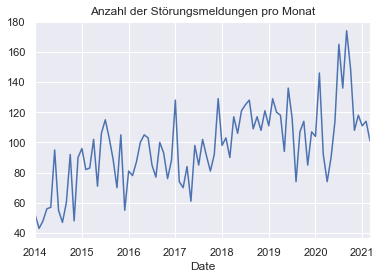

In [193]:
#stoerungen_raw['Text'].groupby(pd.Grouper(freq='W')).count().plot()
stoerungen['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Anzahl der Störungsmeldungen pro Monat')
plt.show()

Wir nehmen nur die Meldungen, wo diese Aufspaltung ein sinnvolles Ergebnis erzeugt und extrahieren einen Typ der Meldung (`type`), einen Text (`Text`) und ein Datum (`Date`).

Als nächstes filtern wir Störungsmeldungen, die häufig auftreten, die aber unsere Analyse nicht verfälschen sollen heraus. Dazu gehören die häufigen Aktualisierungen zu Störungsmeldungen (wir möchten nur die erste, ursprüngliche Störungsmeldung zählen und analysieren) und nehmen auch die häufigen Meldungen zum Ausfall von S-Bahnen des 10-Minuten-Taktes hinaus, weil das meist mit einer Störung zusammenhängt und wir diese dann doppelt oder dreifach zählen würden. Insgesamt möchten wir eher eine Störung nicht zählen, als eine zu viel.

In [194]:
stoerungen_without_10mtakt = stoerungen[~stoerungen['Text'].str.contains('10-minuten-takt')]

# types = np.unique(stoerungen['Type'])
types = np.unique(stoerungen_without_10mtakt['Type'])
types_freq = pd.DataFrame({'Words': types, 'Freq': [np.sum(stoerungen_without_10mtakt['Type'] == typ) for typ in types]})

Hier filtern wir diejenigen Störungen hinaus, die im Typ das Wort Aktualisierung beinhalten. (Die Variable `Keep` beschreibt, ob wir die Meldung behalten möchten oder nicht.)

In [195]:
types_freq['Keep'] = ~types_freq['Words'].str.contains('aktualisierung')

Wir können uns nun diejenigen Meldungstypen mit dem höchsten Auftreten ansehen. Erwartungsgemäß tritt hier die Stammstrecke am häufigsten auf.

In [196]:
types_freq[types_freq['Keep']].sort_values(by='Freq', ascending=False).head(20)

,Words,Freq,Keep
1552,stammstrecke,1345,True
1224,s 7 wolfratshausen,467,True
498,s 2 erding,399,True
315,s 1 freising/flughafen,303,True
1357,s 8 herrsching,297,True
916,s 4 geltendorf,288,True
1165,s 7 kreuzstraße,270,True
258,s 1 freising / flughafen,256,True
740,s 3 holzkirchen,245,True
1087,s 6 tutzing,225,True


Als nächsten sehen wir uns die Erwähnungen der S-Bahnlinien in diesen Meldungen an und zählen sie.

In [197]:
sbahnlinien = ['1', '2', '3', '4', '6', '7', '8']
mentions = dict()

for sbahnlinie in sbahnlinien:
    mentions['S{}'.format(sbahnlinie)] = types_freq['Freq'][(types_freq['Words'].str.contains('s {}'.format(sbahnlinie)) | types_freq['Words'].str.contains('s{}'.format(sbahnlinie))) & types_freq['Keep']].sum()

freq = pd.Series(list(mentions.values()))
sbahnlinie = pd.Series(list(mentions.keys()))
m = pd.concat([sbahnlinie, freq], axis=1)
m.columns = ['S-Bahnlinie', 'Mentions']
m

,S-Bahnlinie,Mentions
0,S1,1072
1,S2,1320
2,S3,691
3,S4,927
4,S6,781
5,S7,1298
6,S8,950


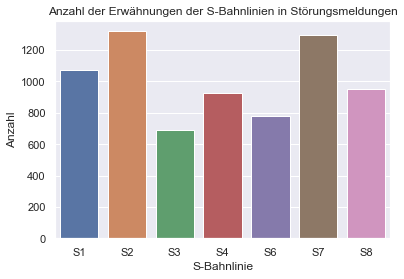

In [214]:
fig, ax = plt.subplots()
sns.barplot(x='S-Bahnlinie', y='Mentions', data=m)
plt.title('Anzahl der Erwähnungen der S-Bahnlinien in Störungsmeldungen')
ax.set_ylabel('Anzahl')
plt.savefig("stoerungen_nach_sbahnlinie.png", dpi=300)
plt.show()

In [199]:
def plot_linien_stoerungen(sbahnlinie):
    monthly_stoerungen_without_updates = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) |
                                                             stoerungen['Type'].str.contains('s{}'.format(sbahnlinie)) |
                                                             stoerungen['Type'].str.contains('stammstrecke')) &
                                                            ~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')] \
        .groupby(pd.Grouper(freq='M')).count()
    monthly_stoerungen = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) |
                                             stoerungen['Type'].str.contains('s{}'.format(sbahnlinie)) |
                                             stoerungen['Type'].str.contains('stammstrecke')) &
                                            ~stoerungen['Text'].str.contains('10-minuten-takt')] \
        .groupby(pd.Grouper(freq='M')).count()

    monthly_stoerungen_without_updates.plot(label='Anzahl')
    monthly_stoerungen_without_updates.rolling(6).mean().plot(title='Anzahl der Störungsmeldungen für die S{} (pro Monat)'.format(sbahnlinie), label='Trendlinie')
    #monthly_stoerungen.plot(label='Count updates')

    #(monthly_stoerungen - monthly_stoerungen_without_updates).plot(label='Difference')

    plt.legend()
    #plt.axhline(y=monthly_stoerungen_without_updates.mean(), color='red')
    #plt.savefig("monatliche_stoeorungen_s{}.png".format(sbahnlinie), dpi=300)
    plt.show()

Als nächstes folgen Grafiken für die S-Bahnlinien zur Anzahl der monatlichen Störungen für die jeweilige S-Bahnlinie (Störungen der Stammstrecke, die alle Linien betreffen, sind hier auch eingerechnet). Weiterhin ist die 6-Monats-Trendlinie eingezeichnet.

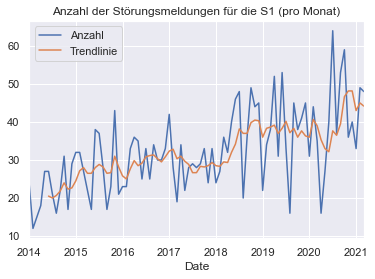

In [200]:
plot_linien_stoerungen(1)

Für die S2 und S8 sollte man bedenken, dass wir die Meldungen zum Ausfall der S-Bahnen des 10-Minuten-Taktes entfernt haben.

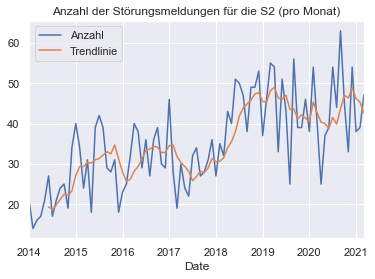

In [201]:
plot_linien_stoerungen(2)

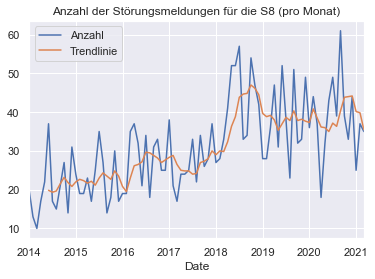

In [202]:
plot_linien_stoerungen(8)

Die letzte Grafik dieser Serie zeigt die Störungen der Stammstrecke (Sxxx).

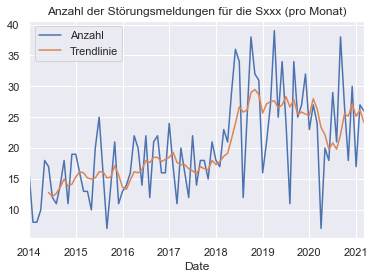

In [203]:
plot_linien_stoerungen('xxx') # results in the disruptions for the stammstrecke

## Gesundheit des Systems

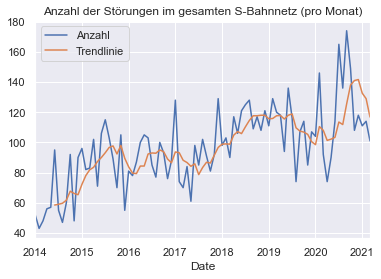

In [204]:
monthly_stoerungen_without_updates = stoerungen['Type'][~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')].groupby(pd.Grouper(freq='M')).count()
monthly_stoerungen_without_updates.plot(label='Anzahl')
monthly_stoerungen_without_updates.rolling(6).mean().plot(title='Anzahl der Störungen im gesamten S-Bahnnetz (pro Monat)', label='Trendlinie')
plt.legend()
plt.show()

## Störungen nach Jahreszeit

Von der Bahn so kommuniziert und eine weitverbreitete Ansicht ist, dass die Zahl der Störungen im Winter nach oben geht und im Sommer eher niedrig ist (Weichen frieren ein, Oberleitungen haben Probleme wegen der Kälte, etc.). Dies können wir an den Daten nun direkt überprüfen. Wir sehen uns dafür die Anzahl der monatlichen Störungen an und teilen die Monate in Kategorien ein.

Wir richten uns nach dem metereologischen Beginn der Jahreszeiten. Das ist damit folgende Einteilung.

| Frühling          | Sommer               | Herbst                       | Winter                        |
|-------------------|----------------------|------------------------------|-------------------------------|
| 1. März - 31. Mai | 1. Juni - 31. August | 1. September - 30. November  | 1. Dezember - 28./29. Februar |
| März, April, Mai  | Juni, Juli, August   | September, Oktober, November | Dezember, Januar, Februar     |

In [205]:
seasons = {
    'Frühling': [3, 4, 5],
    'Sommer': [6, 7, 8],
    'Herbst': [9, 10, 11],
    'Winter': [12, 1, 2],
}

In [206]:
stoerungen_for_month = monthly_stoerungen_without_updates.groupby(by=[monthly_stoerungen_without_updates.index.month]).mean().to_frame()
stoerungen_for_month.columns = ['Durchschnittliche Anzahl']
stoerungen_for_month['Monat'] = stoerungen_for_month.index
stoerungen_for_month['Jahreszeit'] = stoerungen_for_month.index

for season, months in seasons.items():
    stoerungen_for_month.loc[stoerungen_for_month['Monat'].isin(months), 'Jahreszeit'] = season

stoerungen_for_season = stoerungen_for_month.groupby(by='Jahreszeit').mean()
stoerungen_for_season['Jahreszeit'] = stoerungen_for_season.index
stoerungen_for_season

,Durchschnittliche Anzahl,Monat,Jahreszeit
Jahreszeit,,,
Frühling,87.601190,4,Frühling
Herbst,98.476190,10,Herbst
Sommer,104.095238,7,Sommer
Winter,98.297619,5,Winter


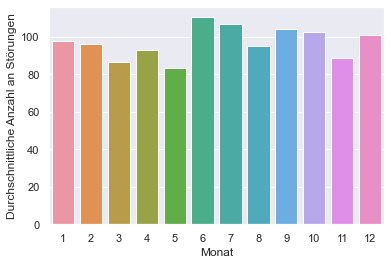

In [207]:
fig, ax = plt.subplots()
sns.barplot(x='Monat', y='Durchschnittliche Anzahl', data=stoerungen_for_month)
ax.set_ylabel('Durchschnittliche Anzahl an Störungen')
plt.savefig("stoerungen_nach_monat.png", dpi=300)
plt.show()

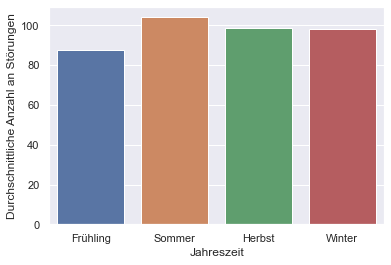

In [208]:
fig, ax = plt.subplots()
sns.barplot(x='Jahreszeit', y='Durchschnittliche Anzahl', data=stoerungen_for_season.loc[("Frühling", "Sommer", "Herbst", "Winter"),:])
ax.set_ylabel('Durchschnittliche Anzahl an Störungen')
plt.savefig("stoerungen_nach_jahreszeit.png", dpi=300)
plt.show()

In [209]:
stoerungen_without_updates_per_hour = stoerungen['Type'][~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')].groupby(pd.Grouper(freq='1h')).count()
stoerungen_without_updates_per_hour = stoerungen_without_updates_per_hour.to_frame()
stoerungen_without_updates_per_hour['timeofday'] = ''

In [210]:
hours = stoerungen_without_updates_per_hour.index.hour
splitting = [0, 6, 9, 12, 15, 18, 21, 24]
sorting = []

for i in range(1, len(splitting)):
    selection = (splitting[i-1] <= hours) & (hours <= splitting[i])
    timeofday = '{} - {}'.format(splitting[i-1], splitting[i])
    sorting.append(timeofday)
    stoerungen_without_updates_per_hour.loc[selection, 'timeofday'] = timeofday

In [211]:
stoerungen_for_timeofday = stoerungen_without_updates_per_hour.groupby(by='timeofday').sum()
stoerungen_for_timeofday['Tageszeit'] = stoerungen_for_timeofday.index
stoerungen_for_timeofday['Anzahl'] = stoerungen_for_timeofday['Type']
stoerungen_for_timeofday = stoerungen_for_timeofday.loc[sorting,]
stoerungen_for_timeofday

,Type,Tageszeit,Anzahl
timeofday,,,
0 - 6,561,0 - 6,561
6 - 9,1672,6 - 9,1672
9 - 12,1178,9 - 12,1178
12 - 15,1173,12 - 15,1173
15 - 18,1828,15 - 18,1828
18 - 21,1366,18 - 21,1366
21 - 24,660,21 - 24,660


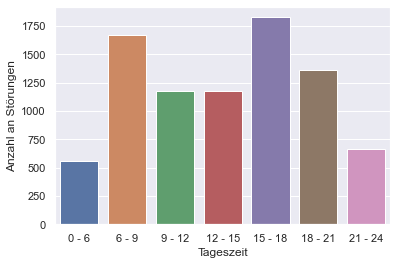

In [212]:
fig, ax = plt.subplots()
sns.barplot(x='Tageszeit', y='Anzahl', data=stoerungen_for_timeofday)
ax.set_ylabel('Anzahl an Störungen')
plt.savefig("stoerungen_nach_tageszeit.png", dpi=300)
plt.show()

### FAQ

Wie häufig pro Monat verspätet/Linie und Station? Welcher Anteil der Fahrten ist verspätet [größtenteils bereits vorhanden, Basisgröße Anzahl der Fahrten könnte ich manuell hochrechnen über den 20min bzw 10min Takt]

- Die Station kann ich aus den vorliegenden Daten nicht auslesen. Ich kann dir natürlich die Verspätungen nach Linie auftrennen. Das ist oben auch berits geschehen.
- Den Anteil der verspäteten Fahren zu bestimmen ist mit den vorliegenden Daten nicht möglich. Sofern wir eine Störungsmeldung haben, wissen wir nicht, welche S-Bahnen das tatsächlich betrifft. Ich habe bisher auch noch keine Daten zur Länge der Störung. Das wäre tatsächlich mein nächster Ansatzpunkt. Das könnte man teils bestimmen, indem man sich die Störungsmeldungen so ansieht, dass man versucht Start und Ende zu finden. Das ist aber nicht ganz so einfach, weil es manchmal keine abschließende Meldung gibt und weil diese auch an einem anderen Tage versendet werden könnte.
- Selbst die Anzahl der Fahrten zu bestimmen ist sehr schwierig. Die variiert je nach Tag und bei den S-Bahnen, die einen 10-Minuten-Takt anbieten ist es meines Erachtens fast unmöglich. Man könnte zwar über den Fahrplan (der sich aber jedes Jahr ändert und man also dafür die Fahrpläne der letzten 7 Jahre analysieren müsste) eine grobe Größe bestimmen für die erwarteten Fahren pro Tag, aber häufig fallen bei den S-Bahnlinien mit 10-Minuten-Takt diese Fahrten aus, weil kein Personal für diesen Takt vorhanden ist.

Wie lange verspätet (ein Pendler verliert xxx Stunden pro Jahr) [nicht möglich, außer wir matchen die Fehlermeldungen mit gleichen IDs (Bahnhof und Schadentyp) pro Tag; eher nice to have]

- Das ist außerhalb der Möglichkeiten dieser Daten, weil ich dir nicht sagen kann, wie viel die eigentlichen S-Bahnen verspätet sind.

Welche Schäden an welchen Stellen (z.B. Weiche Ostbahnhof; interessanterweise sieht man zB Riem relativ häufig in 2021) [Matrix BahnhofxStörung]

- Ich kann hier die Daten nach den wichtigsten Ursachen und den S-Bahnlinien auftrennen. Dann hast du eine Matrix.
- Welche Größe hättest du hier gerne? Störungen pro Woche / pro Monat? Anteil an den Gesamtstörungen für diese Linie? Da gibt es viele Möglichkeiten und da das Ganze sich auch jahresweise entwickelt, müsste man auch eine zeitliche Dimension betrachten.

Ggf ist das Thema Wetter vs Störung auch interessant: anscheinend gibt es Weichen, die einfrieren und kein Signal mehr übertragen können [denke auch eher nice to have]

- Leider habe ich keine Informationen zu den Ursachen der Störungen. Hin und wieder gibt es witterunsbedingte Störungsmeldungen, die sind aber dann so gehalten, dass man nicht weiß, was genau kaputt ist - außer dass es eben Verzögerungen gibt.

Können wir den Ausreißer in 2021 etwas genauer beleuchten? Eine Liste der Fehlermeldungen würde ausreichen denke ich für diesen Zeitraum

- Die Ausreißer in 2021 habe ich schon zurückgedrängt. Meines Erachtens hängt es damit zusammen, dass die S-Bahn immer häufiger solche Störmeldungen veröffentlicht. Dann habe ich für eine Störung plötzlich etliche Meldungen. Das habe ich jetzt aggressiver gefiltert und insofern haben wir weniger Meldungen.

#### Todo

- Häufigste Störungsmeldung pro Monat + pro Linie
- Matrix aus S-Bahnlinie und Störungsmeldungen (vielleicht auch pro Jahr) und anteilig an den Störungsmeldungen der Linie
- Wie viele Störungen pro Woche + pro Linie eingegrenzt auf werktags und 6-9 und 15-21 Uhr?
- Häufigkeit der Störungen nach Monat + Jahreszeiten aggregieren

#### Häufigste Störungsmeldungen pro Monat und / oder pro Linie

In [346]:
hot_words = [
    # 'störung|ausfall|verzögerung|beeinträchtigung',
    'sperrung|streckensperrung',
    'signal|signalstörung',
    'bahnübergang',
    'polizeieinsatz|polizeiliche ermittlungen',
    'personen im gleis',
    'stellwerk',
    'notarzteinsatz|ärztliche versorgung',
    'geänderte linienführung',
    'weiche|weichenstörung',
    'oberleitung',
    'feuerwehr',
    'gegenstände im gleis',
]

In [347]:
stoerungen_hotwords = stoerungen.loc[stoerungen['Text'].str.contains('|'.join(hot_words)), :]
for word in hot_words:
    stoerungen_hotwords = stoerungen_hotwords.assign(**{f'{word}': stoerungen_hotwords.loc[:, 'Text'].str.contains(word).values})

stoerungen_hotwords.sum()

Type                                        stammstreckestammstreckes 4 ebersbergs 4 ebers...
Text                                        notarzteinsatz /  verzögerungen polizeieinsatz...
sperrung|streckensperrung                                                                1142
signal|signalstörung                                                                     1121
bahnübergang                                                                              915
polizeieinsatz|polizeiliche ermittlungen                                                  755
personen im gleis                                                                         386
stellwerk                                                                                 463
notarzteinsatz|ärztliche versorgung                                                       569
geänderte linienführung                                                                    62
weiche|weichenstörung                                       

<AxesSubplot:xlabel='Date'>

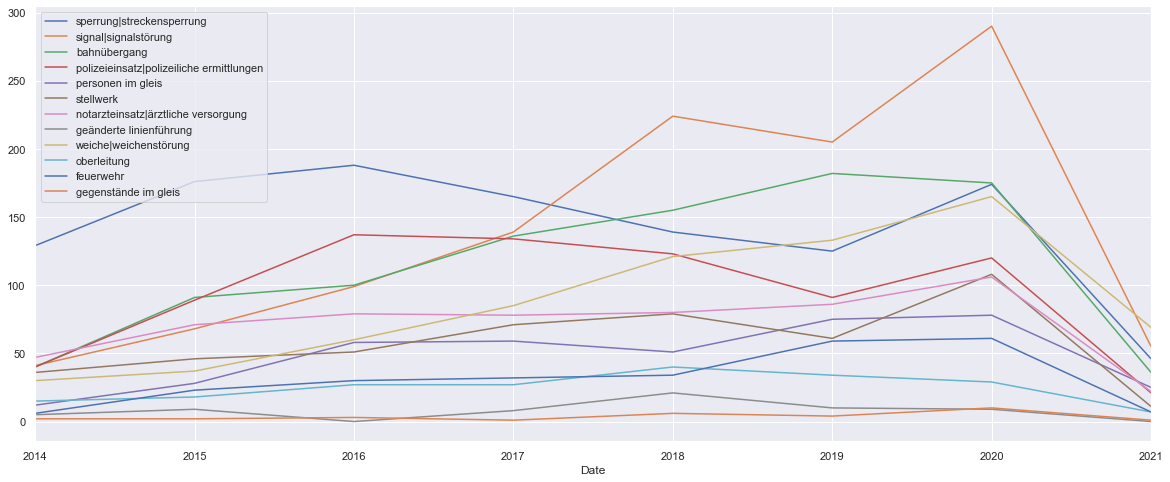

In [350]:
stoerungen_hotwords.groupby(pd.Grouper(freq='Y')).sum().plot(figsize=(20,8))

In [338]:
stoerungen_hotwords.loc[:, 'Month'] = stoerungen_hotwords.index.month
stoerungen_hotwords.loc[:, 'Season'] = stoerungen_hotwords.index

for season, months in seasons.items():
    stoerungen_hotwords.loc[stoerungen_hotwords['Month'].isin(months), 'Season'] = season

stoerungen_hotwords_by_season = stoerungen_hotwords.loc[:, hot_words + ['Season']].groupby(by='Season').sum()

most_by_season = {}
for season in seasons:
    most_by_season[season] = stoerungen_hotwords_by_season.loc['Frühling', :].sort_values(ascending=False).index[:10]

most_by_season

{'Frühling': Index(['störung|ausfall|verzögerung|beeinträchtigung',
        'sperrung|streckensperrung', 'signal|signalstörung', 'bahnübergang',
        'polizeieinsatz|polizeiliche ermittlungen',
        'notarzteinsatz|ärztliche versorgung', 'weiche|weichenstörung',
        'personen im gleis', 'stellwerk', 'feuerwehr'],
       dtype='object'),
 'Sommer': Index(['störung|ausfall|verzögerung|beeinträchtigung',
        'sperrung|streckensperrung', 'signal|signalstörung', 'bahnübergang',
        'polizeieinsatz|polizeiliche ermittlungen',
        'notarzteinsatz|ärztliche versorgung', 'weiche|weichenstörung',
        'personen im gleis', 'stellwerk', 'feuerwehr'],
       dtype='object'),
 'Herbst': Index(['störung|ausfall|verzögerung|beeinträchtigung',
        'sperrung|streckensperrung', 'signal|signalstörung', 'bahnübergang',
        'polizeieinsatz|polizeiliche ermittlungen',
        'notarzteinsatz|ärztliche versorgung', 'weiche|weichenstörung',
        'personen im gleis', 'stellwe

In [339]:
stoerungen_hotwords_by_season

,störung|ausfall|verzögerung|beeinträchtigung,sperrung|streckensperrung,signal|signalstörung,bahnübergang,polizeieinsatz|polizeiliche ermittlungen,personen im gleis,stellwerk,notarzteinsatz|ärztliche versorgung,geänderte linienführung,weiche|weichenstörung,oberleitung,feuerwehr,gegenstände im gleis
Season,,,,,,,,,,,,,
Frühling,1423,306,244,189,173,117,94,133,9,127,50,71,5
Herbst,1653,271,311,211,193,109,121,153,11,147,40,45,10
Sommer,1708,285,311,248,198,80,125,125,12,143,55,85,5
Winter,1777,280,255,267,191,80,123,158,30,283,52,51,9
